In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# In this project we are supposed to predict the sentiment of a given tweet,
#And predict if it is positive, negative or neutral in nature.

**Importing necessary libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/nlp/')

import re
import nltk
import string
import nlp_utils
import collections
import contractions
import nlp_utils as nu
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

**Enabling and testing the GPU**

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.478020767000089
GPU (s):
0.03826372399998945
GPU speedup over CPU: 38x


**Loading data**

In [ ]:
with open('/content/drive/MyDrive/nlp/75kTweets.csv',encoding='UTF-8',mode='r') as f:
    text = f.read()

In [ ]:
#text

# Text Normalization

### Text normalization is the process of transforming a text into a canonical (standard) form. For example, the word “gooood” and “gud” can be transformed to “good”, its canonical form. Another example is mapping of near identical words such as “stopwords”, “stop-words” and “stop words” to just “stopwords”

In [ ]:
# splitting at ( \n ).
text=text.split('\n')
#text
# Separating at new line using '\n'

In [ ]:
# splitting at ( \t ).
corpus = [text]
for sent in text:
    corpus.append(sent.split('\t'))
# Splitting String by tab(\t)   

In [ ]:
letters_only = re.sub(r'[^a-zA-Z]',  
                          " ",          
                          str(corpus))
# Taking only letters

### Tokenization


What is Tokenization? Tokenization is the process by which big quantity of text is divided into smaller parts called tokens.

Natural language processing is used for building applications such as Text classification, intelligent chatbot, sentimental analysis, language translation, etc. It becomes vital to understand the pattern in the text to achieve the above-stated purpose. These tokens are very useful for finding such patterns as well as is considered as a base step for stemming and lemmatization.

Sentence tokenization is the process of splitting text into individual sentences. It does this by looking for the types of textual constructs that confuse the tokenizer and replacing them with single words.

In [ ]:
nltk.download('punkt')

# converting to lowercase.
letters_only=letters_only.lower()

token=nltk.sent_tokenize(letters_only)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Alphanumeric characters

In [ ]:
def num_dec_al(word):
    if word.isnumeric():
        return 'xxxxxx'
    elif word.isdecimal():
        return 'xxx...'
    elif word.isalpha():
        return word
    else:
        return 'xxxaaa'

def clean_nda(token):
    tokens = nlp_utils.w_tokenization(token)
    map_list = list(map(num_dec_al,tokens))
    return " ".join(map_list)

corpus_nda = list(map(clean_nda,token))
### Alpha numeric characters and decimals have been replaced with characters

### Removing Contractions.
It is a process where words like isn't, didn't are expanded to is not, did not. 

In [ ]:
conm = contractions.CONTRACTION_MAP
def contraction_remove(corpus_nda):
    for key,value in conm.items():
        corpus_nda = re.sub(r"{}".format(key),'{}'.format(value),corpus_nda)
        
    return corpus_nda

special = string.punctuation
def w_tokenization(corpus_nda):
    # convert into lower case
    corpus_nda = corpus_nda.lower()
    # contraction
    corpus_nda = contraction_remove(corpus_nda)
    # 
    tokens = nltk.word_tokenize(corpus_nda) # word tokens
## contractions have been expanded and the letters have been converted to lowercase.    

In [ ]:
#corpus_nda
## corpus_nda with expanded contractions and converted to lowercase.    

In [ ]:
data = [corpus_nda]
for sent in text:
    data.append(sent.split('\t'))
# Separating at tab     

In [ ]:
data.append(sent.split('\n'))
# Separating at newline

In [ ]:
#data
# Cleaned text

In [ ]:
df = pd.DataFrame(data)
## Saving the data into a dataframe.

In [ ]:
df

,0
0,now that free speech has finally been restored...
1,",""Now that free speech has finally been restor..."
2,"0,""@GovAbbott let’s bring Twitter to Texas pos..."
3,"1,""@mmmm_oranges If Elon Musk takes over Twitt..."
4,"2,""@elonmusk now that twitter is yours can I p..."
...,...
75537,"75535,@sassyrightwing @Twitter @elonmusk The f..."
75538,"75536,""@Rombbb_Gaming @Twitter @elonmusk i'm n..."
75539,"75537,""@KarenJoyJones22 @hawki1551 @AlastairMc..."
75540,


In [ ]:
df= df.rename(columns={0: 'Text'})
# Renaming the column 0 as 'Text'
df

,Text
0,now that free speech has finally been restored...
1,",""Now that free speech has finally been restor..."
2,"0,""@GovAbbott let’s bring Twitter to Texas pos..."
3,"1,""@mmmm_oranges If Elon Musk takes over Twitt..."
4,"2,""@elonmusk now that twitter is yours can I p..."
...,...
75537,"75535,@sassyrightwing @Twitter @elonmusk The f..."
75538,"75536,""@Rombbb_Gaming @Twitter @elonmusk i'm n..."
75539,"75537,""@KarenJoyJones22 @hawki1551 @AlastairMc..."
75540,


In [ ]:
df=df.drop(df.index[0])

df.drop_duplicates(subset=['Text'])

df['Text'].replace('', np.nan, inplace=True)
df = df.dropna()

df = df.reset_index(drop=True)

df
#final dataset

,Text
0,",""Now that free speech has finally been restor..."
1,"0,""@GovAbbott let’s bring Twitter to Texas pos..."
2,"1,""@mmmm_oranges If Elon Musk takes over Twitt..."
3,"2,""@elonmusk now that twitter is yours can I p..."
4,"3,""@DerpFighter @cenkuygur @elonmusk @Twitter ..."
...,...
75534,"75533,With Elon Musk buying twitter I better g..."
75535,"75534,""@washingtonpost @elonmusk Elon Musk bo..."
75536,"75535,@sassyrightwing @Twitter @elonmusk The f..."
75537,"75536,""@Rombbb_Gaming @Twitter @elonmusk i'm n..."


### Removing additional characters present in the dataframe.

In [ ]:
## We can further see that there are still some special characters in the dataframe which have to be treated.
df.replace('\d+', '', regex=True, inplace=True)
df.replace(',', '', regex=True, inplace=True)
df.replace('br', '', regex=True, inplace=True)
df.replace('"', '', regex=True, inplace=True)
df.replace("'", '', regex=True, inplace=True)
df.replace('?', '', inplace=True)
df.replace("-", '', regex=True, inplace=True)
df.replace("*", '', inplace=True)
df.replace("***", '', inplace=True)
df.replace("< />", '', regex=True, inplace=True)

In [ ]:
df['Text'] = df['Text'].str.strip('[')
df['Text'] = df['Text'].str.strip(']')
df['Text'] = df['Text'].str.strip(')')
df['Text'] = df['Text'].str.strip('(')
## Using the strip function in order to delete the special characters.

In [ ]:
df

,Text
0,Now that free speech has finally been restored...
1,@GovAbbott let’s ing Twitter to Texas possible...
2,@mmmm_oranges If Elon Musk takes over Twitter ...
3,@elonmusk now that twitter is yours can I post...
4,@DerpFighter @cenkuygur @elonmusk @Twitter ht...
...,...
75534,With Elon Musk buying twitter I better get my ...
75535,@washingtonpost @elonmusk Elon Musk bought Tw...
75536,@sassyrightwing @Twitter @elonmusk The filters...
75537,@Rombbb_Gaming @Twitter @elonmusk im not sure ...


## Lemmatization of the text column

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.
Lemmatization will generate the root form of the inflected words

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
pip install swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#df['Text'] = df['Text'].apply(nu.lemmatization_sentence)

import swifter
## A package which efficiently applies any function to a pandas dataframe or series in the fastest available manner 

df['Text'] = df['Text'].swifter.apply(nu.lemmatization_sentence)

Pandas Apply:   0%|          | 0/75542 [00:00<?, ?it/s]

In [ ]:
Text=df['Text']

In [ ]:
token=Text.to_numpy()
## to_numpy() function is used to convert the given series or dataframe object to Numpy-array representation.

In [ ]:
token=nltk.sent_tokenize(str(token))
## Sentence tokenization

In [ ]:
data = np.array(token)
## Saving token in form of array

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop = stopwords.words('english')
## Saving stopwords in stop

### Removing stopwords from the dataframe

In [ ]:
text = data
text_tokens = word_tokenize(str(text))

tokens_without_sw = [word for word in text_tokens if not word in stop]

#print(tokens_without_sw)   
## Removing stopwords from the text and printing the words without stopwords

# Visualization

In [ ]:
stopwords = set(stopwords.words("english"))
## Removing stopwords for wordcloud visualization

In [ ]:
wordcloud = WordCloud(stopwords=stop, background_color="white", max_words=1000).generate(str(tokens_without_sw))
## WordCloud is a technique to show which words are the most frequent among the given text

### Visualizing the highest repeating words in the dataframe using  the wordcloud.

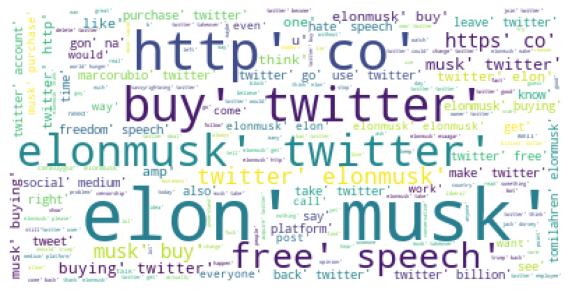

In [ ]:
rcParams['figure.figsize'] = 10, 20
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Counting the number of times a word has repeated through out the data.

In [ ]:
tokens_without_sw=(str(tokens_without_sw))

In [ ]:
filtered_words = [word for word in tokens_without_sw.split() if word not in stopwords]
counted_words = collections.Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)
# Removing stopwords as creating two lists to display the words and their counts    

In [ ]:
counted_words.most_common(100) # the word 'twitter' has repeated for 166959 times.

[("'twitter',", 166959),
 ("'elonmusk',", 106323),
 ("'elon',", 61535),
 ("'musk',", 58719),
 ("'co',", 36672),
 ("'buy',", 29756),
 ("'http',", 26688),
 ("'speech',", 21787),
 ("'free',", 19919),
 ("'people',", 15324),
 ("'like',", 14053),
 ("'get',", 13229),
 ("'go',", 12151),
 ("'say',", 11506),
 ("'make',", 11294),
 ("'u',", 10926),
 ("'https',", 9637),
 ("'think',", 9568),
 ("'back',", 8920),
 ("'want',", 8776),
 ("'take',", 8190),
 ("'billion',", 8032),
 ("'see',", 7950),
 ("'one',", 7673),
 ("'would',", 7526),
 ("'know',", 7230),
 ("'platform',", 7070),
 ("'good',", 6990),
 ("'account',", 6822),
 ("'use',", 6756),
 ("'right',", 6582),
 ("'tesla',", 6518),
 ("'could',", 6414),
 ("'buying',", 6304),
 ("'trump',", 6134),
 ("'tweet',", 5924),
 ("'ban',", 5878),
 ("'amp',", 5860),
 ("'new',", 5810),
 ("'leave',", 5764),
 ("'thing',", 5748),
 ("'world',", 5658),
 ("'change',", 5370),
 ("'time',", 5364),
 ("'purchase',", 5018),
 ("'let',", 4933),
 ("'give',", 4802),
 ("'need',", 4758),

# Visualizing top 10 repeated/common words using bar graph.

<BarContainer object of 10 artists>

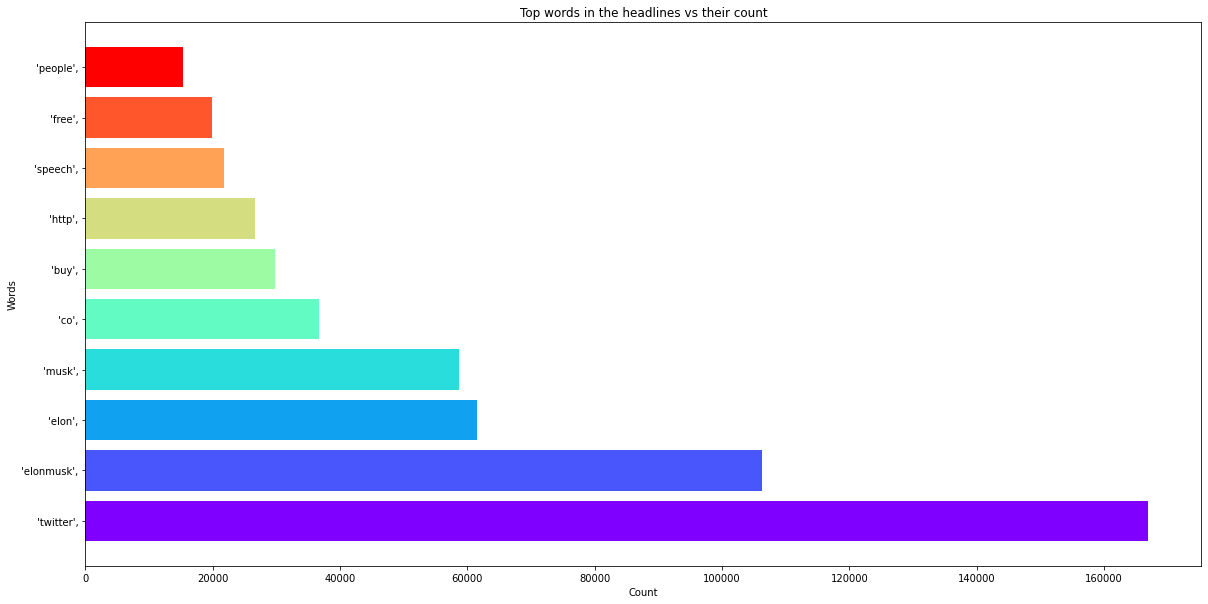

In [ ]:
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words in the headlines vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

# Sentiment Analysis.

### Vader sentiment analysis is done in order to find if a given (Word) is positive, negative or  neutral in nature.
VADER belongs to a type of sentiment analysis that is based on lexicons of sentiment-related words. In this approach, each of the words in the lexicon is rated as to whether it is positive or negative, and in many cases, how positive or negative. Below you can see an excerpt from VADER’s lexicon, where more positive words have higher positive ratings and more negative words have lower negative ratings.
Vader sentiment analysis for a given (word) if positive, negative or  neutral in nature.

In [ ]:
pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sentence = tokens_without_sw
tokenized_sentence = nltk.word_tokenize(sentence)

sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for word in tokenized_sentence:
    if (sid.polarity_scores(word)['compound']) >= 0.1:
        pos_word_list.append(word)
    elif (sid.polarity_scores(word)['compound']) <= -0.1:
        neg_word_list.append(word)
    else:        
        neu_word_list.append(word)                

#print('Positive:',pos_word_list)        
#print('Neutral:',neu_word_list)    
#print('Negative:',neg_word_list) 
#score = sid.polarity_scores(sentence)
#print('\nScores:', score)

In [ ]:
#pos_word_list[:100]
#neg_word_list[:100]

### Top 100 Positive words.

In [ ]:
print(list(iter(pos_word_list[:100]))) # These are the top 100 positive words found in the dataset.

["'free", "'restore", "'thanks", "'hope", "'honest", "'friend", "'sure", "'best", "'like"]


### Top 100 Negative words.

In [ ]:
print(list(iter(neg_word_list[:100]))) # These are the top 100 negative words found in the dataset.

["'drop", "'ban", "'abuse"]


## Vader sentiment analysis for a given (Sentence) if positive, negative or  neutral in nature.

In [ ]:
iopub_data_rate_limit=1e10

In [ ]:
sid = SentimentIntensityAnalyzer()

for sentence in Text:
  print(sentence)
        
  ss = sid.polarity_scores(sentence)
  for k in ss:
    print('{0}: {1}, ' .format(k, ss[k]), end='')
  print()
   

"sid = SentimentIntensityAnalyzer()\n\nfor sentence in Text:\n  print(sentence)\n        \n  ss = sid.polarity_scores(sentence)\n  for k in ss:\n    print('{0}: {1}, ' .format(k, ss[k]), end='')\n  print()"

### Converting all Polarity scores and sentences into a dataframe.

In [ ]:
analyzer = SentimentIntensityAnalyzer()
df['rating'] = Text.swifter.apply(analyzer.polarity_scores)
df=pd.concat([df.drop(['rating'], axis=1), df['rating'].apply(pd.Series)], axis=1)
### Creating a dataframe.

Pandas Apply:   0%|          | 0/75539 [00:00<?, ?it/s]

In [ ]:
df.head()

,Text,neg,neu,pos,compound
0,now that free speech have finally be restore t...,0.000,0.603,0.397,0.9501
1,govabbott let ’ s ing twitter to texas possibl...,0.000,1.000,0.000,0.0000
2,mmmm_oranges if elon musk take over twitter ev...,0.177,0.753,0.070,-0.2500
3,elonmusk now that twitter be yours can i post ...,0.000,0.898,0.102,0.3612
4,derpfighter cenkuygur elonmusk twitter http //...,0.000,0.846,0.154,0.4767


## Arranging the dataset in descending order based on (Compound score) to find the most important sentence from the given data.

In [ ]:
imp_sent=df.sort_values(by='compound', ascending=False)
## arranging the compound column in descending order to find the best sentence. 

In [ ]:
imp_sent 

,Text,neg,neu,pos,compound
23166,we could have have mean tweet but now elon mus...,0.003,0.489,0.508,0.9999
28203,liberaltears at the news ... 😂😂🤣🤣😂🤣😂😂😂🤣🤣😂😂😂🤣🤣🤣...,0.113,0.464,0.423,0.9990
29285,elonmusk ❤️🧡💛💚💜💖 ❤️🧡💛💚💜💖 elon censorship be no...,0.000,0.343,0.657,0.9986
16828,bro elon musk own twitter now🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣...,0.000,0.570,0.430,0.9975
46578,elonmusk have say that from now on twitter wou...,0.173,0.445,0.382,0.9957
...,...,...,...,...,...
25871,comicalgovinda josiahbrewster theprayagtiwari ...,0.420,0.513,0.067,-0.9881
42611,lady and gentleman forget ola btc portable ash...,0.577,0.423,0.000,-0.9951
55219,fuck you fuck you fuck you fuck you fuck you f...,0.712,0.260,0.028,-0.9961
73374,ap tesla elonmusk twitter every liberal who be...,0.561,0.416,0.022,-0.9975


In [ ]:
print(df['Text'].iloc[23166] ) # sentence with index 23166 has the highest compound score 
                             # and hence it is the most important sentence among all the sentences.

we could have have mean tweet but now elon musk own twitter😅😆😂🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣heeheehahaaaaaaaaa🤣🤣🤣🤣🤣🤣🤣🤣🤣


## Finding top positive sentence in the data.

In [ ]:
pos_sent=df.sort_values(by='pos', ascending=False)
## Arranging the dataframe by positive column in descending order to find the best postive sentence.

In [ ]:
pos_sent

,Text,neg,neu,pos,compound
74299,elonmusk congratulation dear enjoy twitter,0.000,0.171,0.829,0.8658
67574,saylor morganlbrennan michaelsantoli elonmusk ...,0.000,0.205,0.795,0.9934
53132,congratulation elonmusk best wish for twitter,0.000,0.217,0.783,0.8957
37196,congratulation elonmusk innovation be beautifu...,0.000,0.224,0.776,0.8860
69103,congrats elonmusktwitter,0.000,0.227,0.773,0.5267
...,...,...,...,...,...
15904,if the discussion stay there twitter serve no ...,0.219,0.781,0.000,-0.7096
7642,chickensandgoa steveolley nigel_farage elonmus...,0.000,1.000,0.000,0.0000
7643,have anyone check on repaoc and her tesla sinc...,0.233,0.767,0.000,-0.8360
7644,sassyrightwing twitter elonmusk hey elon your ...,0.000,1.000,0.000,0.0000


In [ ]:
print(df['Text'].iloc[74299] ) # sentence with index 74299 has the highest positive score and is the most postive. 

elonmusk congratulation dear enjoy twitter


## Finding top negative sentence in the data.

In [ ]:
neg_sent=df.sort_values(by='neg', ascending=False)
## Arranging the dataframe by negative column in descending order to find the best negative sentence.

In [ ]:
#neg_sent

In [ ]:
#print(df['Text'].iloc[53166])# sentence with index 53166 has the highest negative score and is the most negative sentence 

In [ ]:
sentences=df

# Giving threshold values to classify if a given sentence is positive, negative or neutral in nature.

In [ ]:
#Assigning score categories and logic
i = 0

predicted_value = [ ] #empty series to hold our predicted values

while(i<len(sentences)):
    if ((sentences.iloc[i]['compound'] >= 0.5)):
        predicted_value.append('positive')
        i = i+1
    elif ((sentences.iloc[i]['compound'] > 0) & (sentences.iloc[i]['compound'] < 0.5)):
        predicted_value.append('neutral')
        i = i+1
    elif ((sentences.iloc[i]['compound'] <= 0)):
        predicted_value.append('negative')
        i = i+1
## The threshold value will categorize if a given sentence is positive negative or neutral in nature.        

In [ ]:
#predicted_value

### Adding the target or sentiment column to our data frame.

In [ ]:
df['Target'] = predicted_value 
## A new column has been created called as 'Target' with sentiments assigned to a given text.

In [ ]:
df.head()

,Text,neg,neu,pos,compound,Target
0,now that free speech have finally be restore t...,0.000,0.603,0.397,0.9501,positive
1,govabbott let ’ s ing twitter to texas possibl...,0.000,1.000,0.000,0.0000,negative
2,mmmm_oranges if elon musk take over twitter ev...,0.177,0.753,0.070,-0.2500,negative
3,elonmusk now that twitter be yours can i post ...,0.000,0.898,0.102,0.3612,neutral
4,derpfighter cenkuygur elonmusk twitter http //...,0.000,0.846,0.154,0.4767,neutral


Removing/dropping the 'neg', 'neu', 'pos', and 'compound' columns.

In [ ]:
df.drop(['neg','neu','pos','compound'],axis=1,inplace=True)
## Dropping the neg, neu, pos, and compound columns.

In [ ]:
df
## Final dataframe with sentiments.

,Text,Target
0,now that free speech have finally be restore t...,positive
1,govabbott let ’ s ing twitter to texas possibl...,negative
2,mmmm_oranges if elon musk take over twitter ev...,negative
3,elonmusk now that twitter be yours can i post ...,neutral
4,derpfighter cenkuygur elonmusk twitter http //...,neutral
...,...,...
75534,with elon musk buying twitter i good get my ol...,neutral
75535,washingtonpost elonmusk elon musk buy twitter ...,positive
75536,sassyrightwing twitter elonmusk the filter be ...,negative
75537,rombbb_gaming twitter elonmusk im not sure whi...,positive


In [ ]:
df['Target'].value_counts()
### There are 20853 positive, 37155 negative and 17531 neutral columns present in the dataset.

negative    37155
positive    20853
neutral     17531
Name: Target, dtype: int64

In [ ]:
cat_cols=['Target']
le=LabelEncoder()
for i in cat_cols:
    df[i]=le.fit_transform(df[i])
df.dtypes
### Label Encoding the target column.

Text      object
Target     int64
dtype: object

In [ ]:
df['Target'].value_counts()
## Label encoded value_counts()

0    37155
2    20853
1    17531
Name: Target, dtype: int64

In [ ]:
df

,Text,Target
0,now that free speech have finally be restore t...,2
1,govabbott let ’ s ing twitter to texas possibl...,0
2,mmmm_oranges if elon musk take over twitter ev...,0
3,elonmusk now that twitter be yours can i post ...,1
4,derpfighter cenkuygur elonmusk twitter http //...,1
...,...,...
75534,with elon musk buying twitter i good get my ol...,1
75535,washingtonpost elonmusk elon musk buy twitter ...,2
75536,sassyrightwing twitter elonmusk the filter be ...,0
75537,rombbb_gaming twitter elonmusk im not sure whi...,2


In [ ]:
# Vectorizing training data. 
tfidf = TfidfVectorizer() 
X = tfidf.fit_transform(df['Text'])
Y = df['Target']
## Applying Tf-Idf vectorizer on the Text column.

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=40)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)
### Splitting the dataset.

(60431, 70202) (15108, 70202) (60431,) (15108,)


# Logistic Regression

In [ ]:
log_reg = LogisticRegression().fit(X_train, Y_train)

#predict on train 
train_preds = log_reg.predict(X_train)
#accuracy on train
print("Model accuracy on train is: ", accuracy_score(Y_train, train_preds))

#predict on test
test_preds = log_reg.predict(X_test)
#accuracy on test
print("Model accuracy on test is: ", accuracy_score(Y_test, test_preds))

Model accuracy on train is:  0.832933428207377
Model accuracy on test is:  0.757280910775748


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_auc_score, roc_curve, recall_score

# Decision Tree Classifier

In [ ]:
DT = DecisionTreeClassifier().fit(X,Y)

In [ ]:
#predict on train 
train_preds2 = DT.predict(X_train)
#accuracy on train
print("Model accuracy on train is: ", accuracy_score(Y_train, train_preds2))

#predict on test
test_preds2 = DT.predict(X_test)
#accuracy on test
print("Model accuracy on test is: ", accuracy_score(Y_test, test_preds2))
print('-'*50)

#Confusion matrix
print("confusion_matrix train is: ", confusion_matrix(Y_train, train_preds2))
print("confusion_matrix test is: ", confusion_matrix(Y_test, test_preds2))
print('Wrong predictions out of total')
print('-'*50)

# Wrong Predictions made.
print((Y_test !=test_preds2).sum(),'/',((Y_test == test_preds2).sum()+(Y_test != test_preds2).sum()))
print('-'*50)

# Kappa Score
print('KappaScore is: ', metrics.cohen_kappa_score(Y_test,test_preds2))

Model accuracy on train is:  0.9995532094454833
Model accuracy on test is:  0.9994704792163093
--------------------------------------------------
confusion_matrix train is:  [[29735     0     0]
 [    9 13986     0]
 [    6    12 16683]]
confusion_matrix test is:  [[7420    0    0]
 [   1 3535    0]
 [   2    5 4145]]
Wrong predictions out of total
--------------------------------------------------
8 / 15108
--------------------------------------------------
KappaScore is:  0.9991574222978195


In [ ]:
#fit the model on train data 
RF=RandomForestClassifier().fit(X_train,Y_train)
#predict on train 
train_preds3 = RF.predict(X_train)
#accuracy on train
print("Model accuracy on train is: ", accuracy_score(Y_train, train_preds3))

#predict on test
test_preds3 = RF.predict(X_test)
#accuracy on test
print("Model accuracy on test is: ", accuracy_score(Y_test, test_preds3))
print('-'*50)

#Confusion matrix
print("confusion_matrix train is: ", confusion_matrix(Y_train, train_preds3))
print("confusion_matrix test is: ", confusion_matrix(Y_test, test_preds3))
print('Wrong predictions out of total')
print('-'*50)

# Wrong Predictions made.
print((Y_test !=test_preds3).sum(),'/',((Y_test == test_preds3).sum()+(Y_test != test_preds3).sum()))
print('-'*50)

Model accuracy on train is:  0.999619400638745
Model accuracy on test is:  0.6894360603653693
--------------------------------------------------
confusion_matrix train is:  [[29733     2     0]
 [    5 13987     3]
 [    5     8 16688]]
confusion_matrix test is:  [[7041   73  306]
 [2291  737  508]
 [1268  246 2638]]
Wrong predictions out of total
--------------------------------------------------
4692 / 15108
--------------------------------------------------


In [ ]:
#fit the model on train data 
KNN = KNeighborsClassifier().fit(X_train,Y_train)
#predict on train 
train_preds4 = KNN.predict(X_train)
#accuracy on train
print("Model accuracy on train is: ", accuracy_score(Y_train, train_preds4))

#predict on test
test_preds4 = KNN.predict(X_test)
#accuracy on test
print("Model accuracy on test is: ", accuracy_score(Y_test, test_preds4))
print('-'*50)

#Confusion matrix
print("confusion_matrix train is: ", confusion_matrix(Y_train, train_preds4))
print("confusion_matrix test is: ", confusion_matrix(Y_test, test_preds4))
print('Wrong predictions out of total')
print('-'*50)

# Wrong Predictions made.
print((Y_test !=test_preds4).sum(),'/',((Y_test == test_preds4).sum()+(Y_test != test_preds4).sum()))
print('-'*50)

Model accuracy on train is:  0.6922605947278715
Model accuracy on test is:  0.5873709293089754
--------------------------------------------------
confusion_matrix train is:  [[27687  1244   804]
 [ 7158  5964   873]
 [ 6289  2229  8183]]
confusion_matrix test is:  [[6367  668  385]
 [2224  960  352]
 [1901  704 1547]]
Wrong predictions out of total
--------------------------------------------------
6234 / 15108
--------------------------------------------------


# Support Vector Machine

In [ ]:
#fit the model on train data 
SVM = SVC(kernel='linear')
SVM.fit(X_train, Y_train)

#predict on train 
train_preds5 = SVM.predict(X_train)
#accuracy on train
print("Model accuracy on train is: ", accuracy_score(Y_train, train_preds5))

#predict on test
test_preds5 = SVM.predict(X_test)
#accuracy on test
print("Model accuracy on test is: ", accuracy_score(Y_test, test_preds5))
print('-'*50)

#Confusion matrix
print("confusion_matrix train is: ", confusion_matrix(Y_train, train_preds5))
print("confusion_matrix test is: ", confusion_matrix(Y_test, test_preds5))
print('Wrong predictions out of total')
print('-'*50)

# Wrong Predictions made.
print((Y_test !=test_preds5).sum(),'/',((Y_test == test_preds5).sum()+(Y_test != test_preds5).sum()))
print('-'*50)

Model accuracy on train is:  0.8686270291737684
Model accuracy on test is:  0.7839555202541699
--------------------------------------------------
confusion_matrix train is:  [[28445   779   511]
 [ 2793  9801  1401]
 [ 1317  1138 14246]]
confusion_matrix test is:  [[6868  361  191]
 [1126 1877  533]
 [ 447  606 3099]]
Wrong predictions out of total
--------------------------------------------------
3264 / 15108
--------------------------------------------------
